# Heart Disease Prediction

Dataset: Using CDC's 2022 annual survey data of 400k+ adults related to their health status, that has been curated by Kamil Pytlak on Kaggle. https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease/data

In [214]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer, MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler

In [215]:
url = 'heart_2022_with_nans.csv'
df_raw = pd.read_csv(url)

df_raw.head()

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,Alabama,Female,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,8.0,NaN,No,...,NaN,NaN,NaN,No,No,Yes,No,"Yes, received tetanus shot but not sure what type",No,No
1,Alabama,Female,Excellent,0.0,0.0,NaN,No,6.0,NaN,No,...,1.60,68.04,26.57,No,No,No,No,"No, did not receive any tetanus shot in the pa...",No,No
2,Alabama,Female,Very good,2.0,3.0,Within past year (anytime less than 12 months ...,Yes,5.0,NaN,No,...,1.57,63.50,25.61,No,No,No,No,NaN,No,Yes
3,Alabama,Female,Excellent,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,7.0,NaN,No,...,1.65,63.50,23.30,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,No
4,Alabama,Female,Fair,2.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,NaN,No,...,1.57,53.98,21.77,Yes,No,No,Yes,"No, did not receive any tetanus shot in the pa...",No,No


# Preprocessing

Checking the missing value in the dataset

In [216]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445132 entries, 0 to 445131
Data columns (total 40 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   State                      445132 non-null  object 
 1   Sex                        445132 non-null  object 
 2   GeneralHealth              443934 non-null  object 
 3   PhysicalHealthDays         434205 non-null  float64
 4   MentalHealthDays           436065 non-null  float64
 5   LastCheckupTime            436824 non-null  object 
 6   PhysicalActivities         444039 non-null  object 
 7   SleepHours                 439679 non-null  float64
 8   RemovedTeeth               433772 non-null  object 
 9   HadHeartAttack             442067 non-null  object 
 10  HadAngina                  440727 non-null  object 
 11  HadStroke                  443575 non-null  object 
 12  HadAsthma                  443359 non-null  object 
 13  HadSkinCancer              44

1. Handle Missing Value and Outliers in numerical column

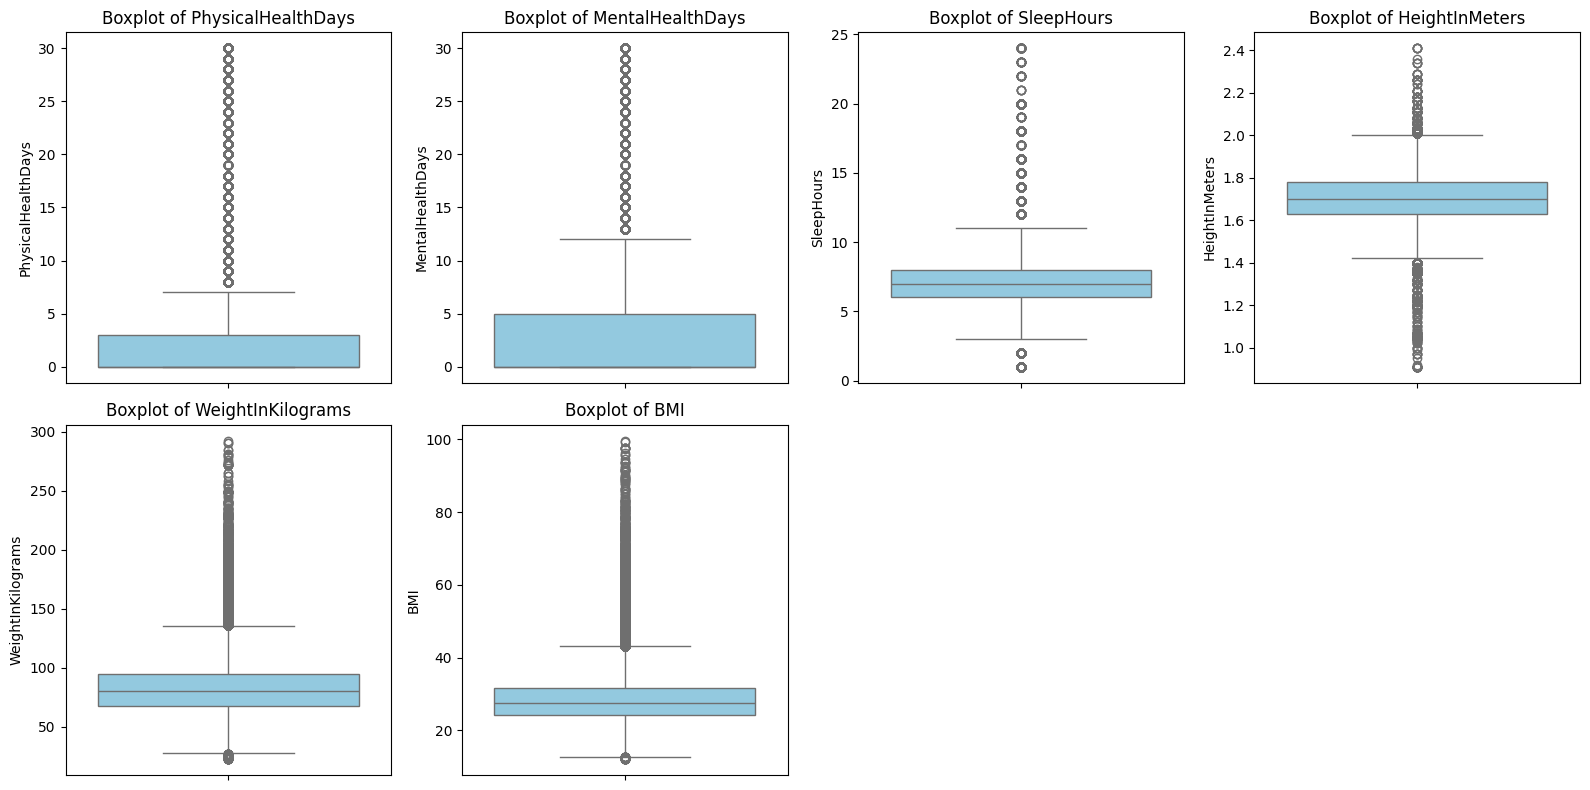

In [217]:
# Select only numerical columns
numeric_features = df_raw.select_dtypes(include=['number']).columns

# Define the number of columns per row for the plots
n_cols = 4  # Number of columns in each row
n_rows = -(-len(numeric_features) // n_cols)  # Calculate number of rows needed

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
axes = axes.flatten()  # Flatten the axes array for easier indexing

# Loop through each numerical column and create a boxplot
for i, col in enumerate(numeric_features):
    sns.boxplot(y=df_raw[col], ax=axes[i], color='skyblue')
    axes[i].set_title(f'Boxplot of {col}')
    axes[i].set_ylabel(col)

# Remove any empty subplots if the grid has extra spaces
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


- Using median to insert value in the missing data for PhysicalHealthDay, MentalHealthDay, SleepHours, WeightInKilograms, and BMI because the data distribution is skewed.
- Using mean to insert value in the missing data for HeightInKilograms because the data distribution is normal (not skewed).

In [218]:
# Handle missing values for numerical columns based on their data distribution
df_raw['PhysicalHealthDays'] = df_raw['PhysicalHealthDays'].fillna(df_raw['PhysicalHealthDays'].median())
df_raw['MentalHealthDays'] = df_raw['MentalHealthDays'].fillna(df_raw['MentalHealthDays'].median())
df_raw['SleepHours'] = df_raw['SleepHours'].fillna(df_raw['SleepHours'].median())
df_raw['WeightInKilograms'] = df_raw['WeightInKilograms'].fillna(df_raw['WeightInKilograms'].median())
df_raw['BMI'] = df_raw['BMI'].fillna(df_raw['BMI'].median())

df_raw['HeightInMeters'] = df_raw['HeightInMeters'].fillna(df_raw['HeightInMeters'].mean())

Use describe to see data distribution in numerical column

In [219]:
df_raw.describe()

,PhysicalHealthDays,MentalHealthDays,SleepHours,HeightInMeters,WeightInKilograms,BMI
count,445132.000000,445132.000000,445132.000000,445132.000000,445132.000000,445132.000000
mean,4.241187,4.293378,7.022701,1.702691,82.853795,28.410347
std,8.607936,8.324664,1.493196,0.103671,20.420694,6.194472
min,0.000000,0.000000,1.000000,0.910000,22.680000,12.020000
25%,0.000000,0.000000,6.000000,1.630000,68.490000,24.410000
50%,0.000000,0.000000,7.000000,1.700000,80.740000,27.440000
75%,3.000000,4.000000,8.000000,1.780000,91.630000,31.010000
max,30.000000,30.000000,24.000000,2.410000,292.570000,99.640000


Because we are in a healthcare dataset, we value the outliers data cause it can mean something. We only handle anomaly outliers like in SleepHours column we found a max of 24hrs of sleep which is almost impossible.

In [220]:
df_raw['SleepHours'] = df_raw['SleepHours'].apply(lambda x: 9 if x > 9 else x)

2. Handle Missing Value (Categorical Column)

Checking the uniques values in each cateforical column

In [221]:
# Filter out numerical columns
categorical_columns = df_raw.select_dtypes(exclude=['number']).columns

# Iterate over each categorical column and print unique values
for column in categorical_columns:
    unique_values = df_raw[column].unique()
    print(f"Column: {column}")
    print(f"Number of Unique Values: {len(unique_values)}")
    print(f"Sample Values: {unique_values}")  # Show only the first 10 unique values
    print("-" * 50)

Column: State
Number of Unique Values: 54
Sample Values: ['Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California' 'Colorado'
 'Connecticut' 'Delaware' 'District of Columbia' 'Florida' 'Georgia'
 'Hawaii' 'Idaho' 'Illinois' 'Indiana' 'Iowa' 'Kansas' 'Kentucky'
 'Louisiana' 'Maine' 'Maryland' 'Massachusetts' 'Michigan' 'Minnesota'
 'Mississippi' 'Missouri' 'Montana' 'Nebraska' 'Nevada' 'New Hampshire'
 'New Jersey' 'New Mexico' 'New York' 'North Carolina' 'North Dakota'
 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania' 'Rhode Island' 'South Carolina'
 'South Dakota' 'Tennessee' 'Texas' 'Utah' 'Vermont' 'Virginia'
 'Washington' 'West Virginia' 'Wisconsin' 'Wyoming' 'Guam' 'Puerto Rico'
 'Virgin Islands']
--------------------------------------------------
Column: Sex
Number of Unique Values: 2
Sample Values: ['Female' 'Male']
--------------------------------------------------
Column: GeneralHealth
Number of Unique Values: 6
Sample Values: ['Very good' 'Excellent' 'Fair' 'Poor' 'Good' nan]
----------

Checking how many missing value in each categorical column

In [222]:
# Select categorical columns
categorical_columns = df_raw.select_dtypes(include=['object']).columns

# Calculate the percentage of missing data for each categorical column
missing_percentages = df_raw[categorical_columns].isnull().mean() * 100

# Print the results
for col, percentage in missing_percentages.items():
    print(f"Column: {col}, Missing Data: {percentage:.2f}%")

Column: State, Missing Data: 0.00%
Column: Sex, Missing Data: 0.00%
Column: GeneralHealth, Missing Data: 0.27%
Column: LastCheckupTime, Missing Data: 1.87%
Column: PhysicalActivities, Missing Data: 0.25%
Column: RemovedTeeth, Missing Data: 2.55%
Column: HadHeartAttack, Missing Data: 0.69%
Column: HadAngina, Missing Data: 0.99%
Column: HadStroke, Missing Data: 0.35%
Column: HadAsthma, Missing Data: 0.40%
Column: HadSkinCancer, Missing Data: 0.71%
Column: HadCOPD, Missing Data: 0.50%
Column: HadDepressiveDisorder, Missing Data: 0.63%
Column: HadKidneyDisease, Missing Data: 0.43%
Column: HadArthritis, Missing Data: 0.59%
Column: HadDiabetes, Missing Data: 0.24%
Column: DeafOrHardOfHearing, Missing Data: 4.64%
Column: BlindOrVisionDifficulty, Missing Data: 4.84%
Column: DifficultyConcentrating, Missing Data: 5.45%
Column: DifficultyWalking, Missing Data: 5.39%
Column: DifficultyDressingBathing, Missing Data: 5.37%
Column: DifficultyErrands, Missing Data: 5.76%
Column: SmokerStatus, Missing

- We are dropping column which are unrelated to our target variable 'HadHeartAttack', 'HadAngina', and 'HadStroke'. All of them are Heart Disease that related to cardiovascular disease.
- For low missing value, we just impute them with mode to preserve original data distribution and it wont bias the dataset significantly
- For medium missing value, we impute them with reasonable default value instead of mode because it might bias the dataset.
- For high missing value, we use new uniques value such as 'unknown' to prevent any bias in the dataset

In [223]:
# List of columns to drop based on earlier analysis
columns_to_drop = [
    'State',
    'DeafOrHardOfHearing', 
    'BlindOrVisionDifficulty', 
    'HIVTesting', 
    'FluVaxLast12', 
    'PneumoVaxEver', 
    'TetanusLast10Tdap',
    'RemovedTeeth',
    'LastCheckupTime'
]

# Drop the low-relevance columns
data_preprocessed = df_raw.drop(columns=columns_to_drop)

# Handle missing df_raw for low missingness columns (<5%) with mode
low_missing_columns = [
    'GeneralHealth', 'PhysicalActivities',
    'HadHeartAttack', 'HadAngina', 'HadStroke', 'HadAsthma', 'HadSkinCancer',
    'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis',
    'HadDiabetes', 'RaceEthnicityCategory', 'AgeCategory'
]

for col in low_missing_columns:
    data_preprocessed[col] = data_preprocessed[col].fillna(data_preprocessed[col].mode()[0])

# Handle missing data for moderate missingness columns (5%-10%)
moderate_missing_values = {
    'DifficultyConcentrating': 'No',
    'DifficultyWalking': 'No',
    'DifficultyDressingBathing': 'No',
    'DifficultyErrands': 'No',
    'SmokerStatus': 'Never smoked',
    'ECigaretteUsage': 'Not at all (right now)'
}

for col, fill_value in moderate_missing_values.items():
    data_preprocessed[col] = data_preprocessed[col].fillna(fill_value)

# Handle missing data for high missingness columns (10%-20%) with "Unknown"
high_missing_values = {
    'ChestScan': 'No Scan',
    'AlcoholDrinkers': 'Unknown',
    'HighRiskLastYear': 'Unknown',
    'CovidPos': 'Unknown'
}

for col, fill_value in high_missing_values.items():
    data_preprocessed[col] = data_preprocessed[col].fillna(fill_value)

Check again the data with info and describe to make sure all secured

In [224]:
data_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445132 entries, 0 to 445131
Data columns (total 31 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Sex                        445132 non-null  object 
 1   GeneralHealth              445132 non-null  object 
 2   PhysicalHealthDays         445132 non-null  float64
 3   MentalHealthDays           445132 non-null  float64
 4   PhysicalActivities         445132 non-null  object 
 5   SleepHours                 445132 non-null  float64
 6   HadHeartAttack             445132 non-null  object 
 7   HadAngina                  445132 non-null  object 
 8   HadStroke                  445132 non-null  object 
 9   HadAsthma                  445132 non-null  object 
 10  HadSkinCancer              445132 non-null  object 
 11  HadCOPD                    445132 non-null  object 
 12  HadDepressiveDisorder      445132 non-null  object 
 13  HadKidneyDisease           44

In [225]:
data_preprocessed.describe()

,PhysicalHealthDays,MentalHealthDays,SleepHours,HeightInMeters,WeightInKilograms,BMI
count,445132.000000,445132.000000,445132.000000,445132.000000,445132.000000,445132.000000
mean,4.241187,4.293378,6.950877,1.702691,82.853795,28.410347
std,8.607936,8.324664,1.282987,0.103671,20.420694,6.194472
min,0.000000,0.000000,1.000000,0.910000,22.680000,12.020000
25%,0.000000,0.000000,6.000000,1.630000,68.490000,24.410000
50%,0.000000,0.000000,7.000000,1.700000,80.740000,27.440000
75%,3.000000,4.000000,8.000000,1.780000,91.630000,31.010000
max,30.000000,30.000000,9.000000,2.410000,292.570000,99.640000


# Label Encoding

Use label encoding for the encoder because mostly the data are binary and ordinal

In [226]:
# Create a dictionary to store label encodings for each column
label_encodings = {}

# List of categorical columns to encode
categorical_columns = data_preprocessed.select_dtypes(include=['object']).columns

# Apply label encoding to each categorical column
for col in categorical_columns:
    le = LabelEncoder()
    # Fit and transform the column
    data_preprocessed[col] = le.fit_transform(data_preprocessed[col].astype(str))
    # Store the mapping of labels for reference
    label_encodings[col] = dict(zip(le.classes_, le.transform(le.classes_)))

# Display the encoding mappings
for col, mapping in label_encodings.items():
    print(f"Column: {col}")
    for category, label in mapping.items():
        print(f"  {category} -> {label}")
    print("-" * 50)


Column: Sex
  Female -> 0
  Male -> 1
--------------------------------------------------
Column: GeneralHealth
  Excellent -> 0
  Fair -> 1
  Good -> 2
  Poor -> 3
  Very good -> 4
--------------------------------------------------
Column: PhysicalActivities
  No -> 0
  Yes -> 1
--------------------------------------------------
Column: HadHeartAttack
  No -> 0
  Yes -> 1
--------------------------------------------------
Column: HadAngina
  No -> 0
  Yes -> 1
--------------------------------------------------
Column: HadStroke
  No -> 0
  Yes -> 1
--------------------------------------------------
Column: HadAsthma
  No -> 0
  Yes -> 1
--------------------------------------------------
Column: HadSkinCancer
  No -> 0
  Yes -> 1
--------------------------------------------------
Column: HadCOPD
  No -> 0
  Yes -> 1
--------------------------------------------------
Column: HadDepressiveDisorder
  No -> 0
  Yes -> 1
--------------------------------------------------
Column: HadKidneyDis

# Feature Selection

1. We use domain knowledge to select which feature is important and relevant to each target variable.

In [227]:
# General features used for all diseases
general_features = [
    'AgeCategory', 'Sex', 'SmokerStatus', 'PhysicalActivities', 
    'BMI', 'WeightInKilograms', 'HeightInMeters', 'GeneralHealth'
]

# Specific features for Heart Attack
specific_features_heart_attack = [
    'SleepHours', 'HadAngina', 'HadStroke', 'HadCOPD', 'HadKidneyDisease', 'HadArthritis', 
    'HadDepressiveDisorder', 'AlcoholDrinkers', 'DifficultyWalking', 'DifficultyErrands'
]

# Specific features for Angina
specific_features_angina = [
    'PhysicalHealthDays', 'MentalHealthDays', 'HadHeartAttack', 
    'HadStroke', 'HadArthritis', 'AlcoholDrinkers'
]

# Specific features for Stroke
specific_features_stroke = [
    'SleepHours', 'HadHeartAttack', 'HadAngina', 'HadDiabetes', 'HadCOPD', 
    'HadKidneyDisease', 'HadArthritis', 'DifficultyWalking', 'DifficultyErrands'
]

# Combine general and specific features for each disease
features_heart_attack = general_features + specific_features_heart_attack + ['HadHeartAttack']
features_angina = general_features + specific_features_angina + ['HadAngina']
features_stroke = general_features + specific_features_stroke + ['HadStroke']

# Create datasets for each target
dataset_heart_attack = data_preprocessed[features_heart_attack]
dataset_angina = data_preprocessed[features_angina]
dataset_stroke = data_preprocessed[features_stroke]

# Save datasets for further processing if needed
# dataset_heart_attack.to_csv('dataset_heart_attack.csv', index=False)
# dataset_angina.to_csv('dataset_angina.csv', index=False)
# dataset_stroke.to_csv('dataset_stroke.csv', index=False)

# Display dataset summaries
print("Heart Attack Dataset Shape:", dataset_heart_attack.shape)
print("Angina Dataset Shape:", dataset_angina.shape)
print("Stroke Dataset Shape:", dataset_stroke.shape)


Heart Attack Dataset Shape: (445132, 19)
Angina Dataset Shape: (445132, 15)
Stroke Dataset Shape: (445132, 18)


2. Second, we check the linear relation of target variables with heatmap to filter out more

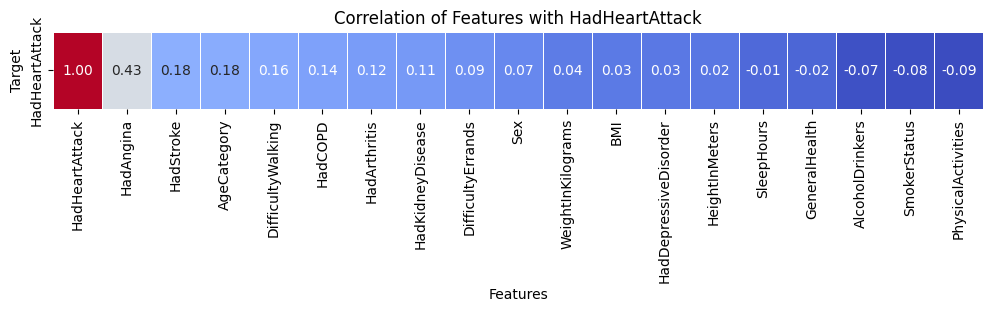

In [228]:
# Calculate correlation matrix
correlation_matrix = dataset_heart_attack.corr()

# Extract correlations with the target variable 'HadHeartAttack'
target_correlation = correlation_matrix[['HadHeartAttack']].sort_values(by='HadHeartAttack', ascending=False)

# Plot horizontal heatmap
plt.figure(figsize=(12, 1))
sns.heatmap(target_correlation.T, annot=True, fmt=".2f", cmap='coolwarm', cbar=False, linewidths=0.5)
plt.title('Correlation of Features with HadHeartAttack')
plt.xlabel('Features')
plt.ylabel('Target')
plt.show()

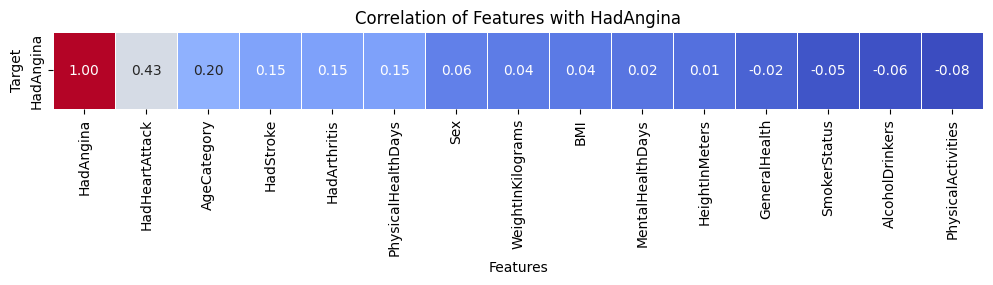

In [229]:
# Calculate correlation matrix
correlation_matrix = dataset_angina.corr()

# Extract correlations with the target variable 'HadAngina'
target_correlation = correlation_matrix[['HadAngina']].sort_values(by='HadAngina', ascending=False)

# Plot horizontal heatmap
plt.figure(figsize=(12, 1))
sns.heatmap(target_correlation.T, annot=True, fmt=".2f", cmap='coolwarm', cbar=False, linewidths=0.5)
plt.title('Correlation of Features with HadAngina')
plt.xlabel('Features')
plt.ylabel('Target')
plt.show()

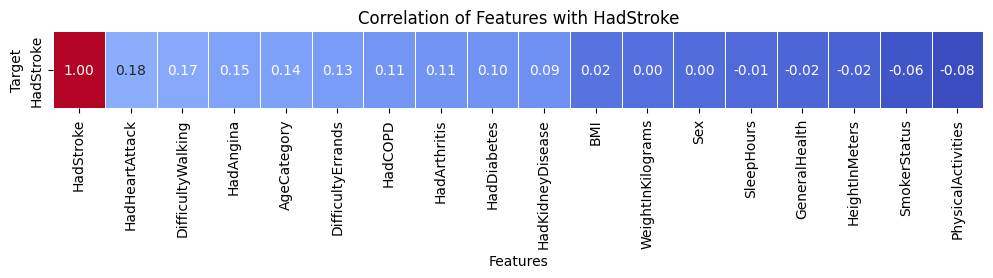

In [230]:
# Calculate correlation matrix
correlation_matrix = dataset_stroke.corr()

# Extract correlations with the target variable 'HadStroke'
target_correlation = correlation_matrix[['HadStroke']].sort_values(by='HadStroke', ascending=False)

# Plot horizontal heatmap
plt.figure(figsize=(12, 1))
sns.heatmap(target_correlation.T, annot=True, fmt=".2f", cmap='coolwarm', cbar=False, linewidths=0.5)
plt.title('Correlation of Features with HadStroke')
plt.xlabel('Features')
plt.ylabel('Target')
plt.show()

3. Last we also check important feature with random forest feature importance to see and capture any strong non-linear relationship that heatmap misses

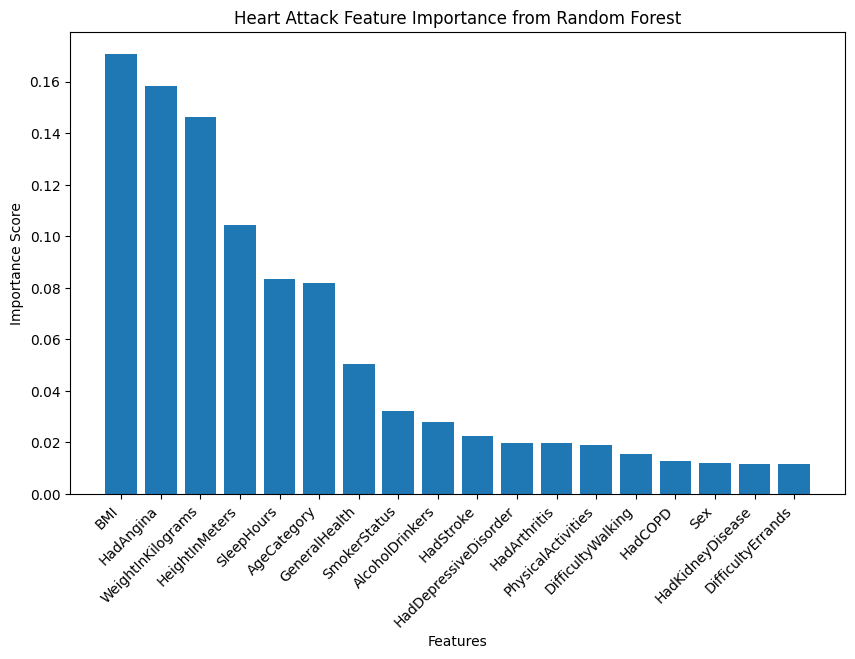

In [231]:
X = dataset_heart_attack.drop(columns=['HadHeartAttack'])
y = dataset_heart_attack['HadHeartAttack']

rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(feature_importance['Feature'], feature_importance['Importance'])
plt.xticks(rotation=45, ha='right')
plt.title('Heart Attack Feature Importance from Random Forest')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.show()

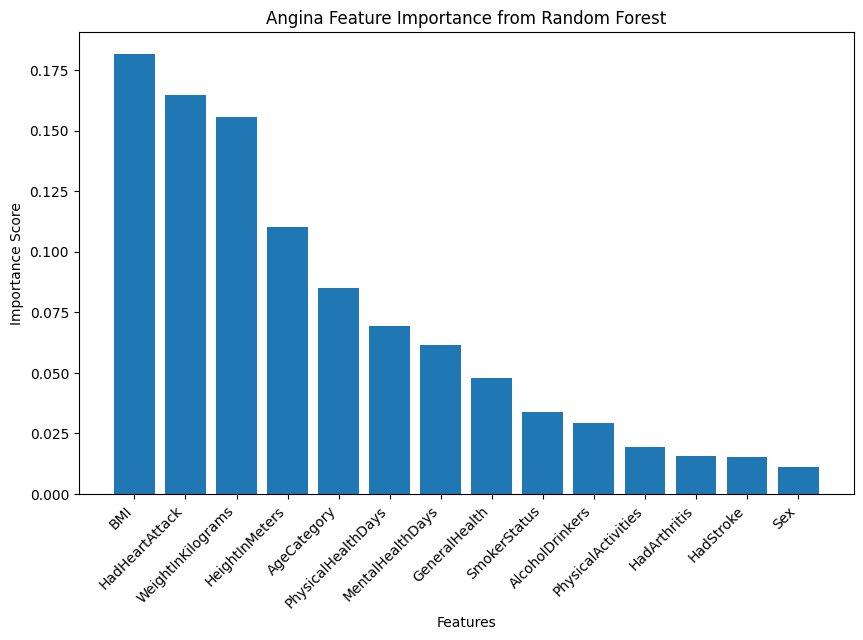

In [232]:
X = dataset_angina.drop(columns=['HadAngina'])
y = dataset_angina['HadAngina']

rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(feature_importance['Feature'], feature_importance['Importance'])
plt.xticks(rotation=45, ha='right')
plt.title('Angina Feature Importance from Random Forest')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.show()

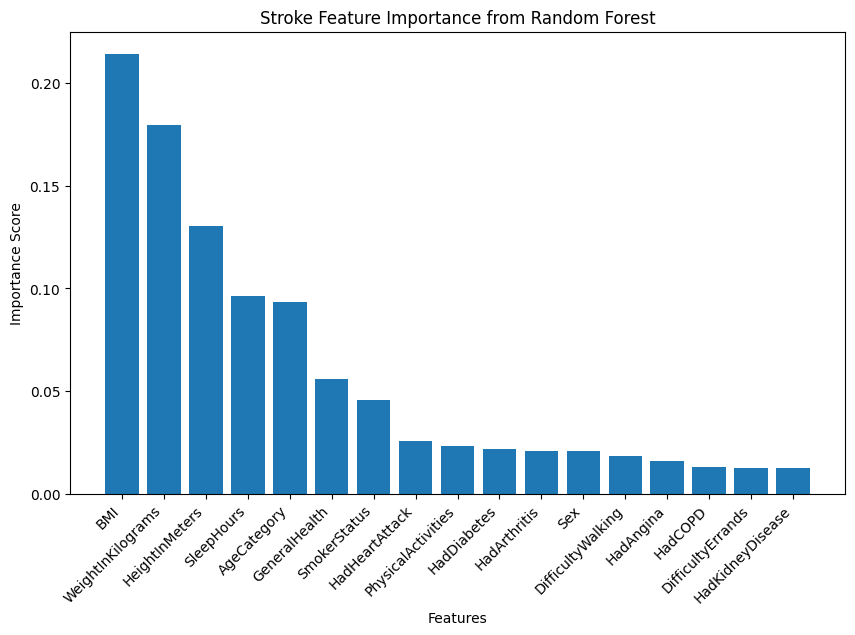

In [233]:
X = dataset_stroke.drop(columns=['HadStroke'])
y = dataset_stroke['HadStroke']

rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(feature_importance['Feature'], feature_importance['Importance'])
plt.xticks(rotation=45, ha='right')
plt.title('Stroke Feature Importance from Random Forest')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.show()

4. Finally we remove those attribute with low contribution in the random forest feature importance

In [234]:
final_heart_attack_feature = [
    'BMI', 'HadAngina', 'WeightInKilograms', 'HeightInMeters', 'SleepHours', 'AgeCategory', 'GeneralHealth', 'SmokerStatus'
] + ['HadHeartAttack']

final_angina_feature = [
    'BMI', 'WeightInKilograms', 'HeightInMeters', 'AgeCategory', 'PhysicalHealthDays', 'MentalHealthDays', 'GeneralHealth', 'SmokerStatus'
] + ['HadAngina']

final_stroke_feature = [
    'BMI', 'WeightInKilograms', 'HeightInMeters', 'SleepHours', 'AgeCategory', 'GeneralHealth', 'SmokerStatus', 'HadHeartAttack'
] + ['HadStroke']


dataset_final_heart_attack = dataset_heart_attack[final_heart_attack_feature]
dataset_final_angina = dataset_angina[final_angina_feature]
dataset_final_stroke = dataset_stroke[final_stroke_feature]

In [235]:
dataset_final_heart_attack.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445132 entries, 0 to 445131
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   BMI                445132 non-null  float64
 1   HadAngina          445132 non-null  int64  
 2   WeightInKilograms  445132 non-null  float64
 3   HeightInMeters     445132 non-null  float64
 4   SleepHours         445132 non-null  float64
 5   AgeCategory        445132 non-null  int64  
 6   GeneralHealth      445132 non-null  int64  
 7   SmokerStatus       445132 non-null  int64  
 8   HadHeartAttack     445132 non-null  int64  
dtypes: float64(4), int64(5)
memory usage: 30.6 MB


In [236]:
dataset_final_angina.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445132 entries, 0 to 445131
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   BMI                 445132 non-null  float64
 1   WeightInKilograms   445132 non-null  float64
 2   HeightInMeters      445132 non-null  float64
 3   AgeCategory         445132 non-null  int64  
 4   PhysicalHealthDays  445132 non-null  float64
 5   MentalHealthDays    445132 non-null  float64
 6   GeneralHealth       445132 non-null  int64  
 7   SmokerStatus        445132 non-null  int64  
 8   HadAngina           445132 non-null  int64  
dtypes: float64(5), int64(4)
memory usage: 30.6 MB


In [237]:
dataset_final_stroke.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445132 entries, 0 to 445131
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   BMI                445132 non-null  float64
 1   WeightInKilograms  445132 non-null  float64
 2   HeightInMeters     445132 non-null  float64
 3   SleepHours         445132 non-null  float64
 4   AgeCategory        445132 non-null  int64  
 5   GeneralHealth      445132 non-null  int64  
 6   SmokerStatus       445132 non-null  int64  
 7   HadHeartAttack     445132 non-null  int64  
 8   HadStroke          445132 non-null  int64  
dtypes: float64(4), int64(5)
memory usage: 30.6 MB


# Undersampling

In the dataset, the target variable is very imbalance, with average of 90% is not having the disease. So we undersampling it.

In [238]:
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)

X_heart = dataset_final_heart_attack.drop('HadHeartAttack', axis=1)
y_heart = dataset_final_heart_attack['HadHeartAttack']
X_heart_resampled, y_heart_resampled = undersampler.fit_resample(X_heart, y_heart)
dataset_final_heart_attack = pd.concat([X_heart_resampled, y_heart_resampled], axis=1)

X_angina = dataset_final_angina.drop('HadAngina', axis=1)
y_angina = dataset_final_angina['HadAngina']
X_angina_resampled, y_angina_resampled = undersampler.fit_resample(X_angina, y_angina)
dataset_final_angina = pd.concat([X_angina_resampled, y_angina_resampled], axis=1)

X_stroke = dataset_final_stroke.drop('HadStroke', axis=1)
y_stroke = dataset_final_stroke['HadStroke']
X_stroke_resampled, y_stroke_resampled = undersampler.fit_resample(X_stroke, y_stroke)
dataset_final_stroke = pd.concat([X_stroke_resampled, y_stroke_resampled], axis=1)

print("Class distribution in heartattack_df:")
print(dataset_final_heart_attack['HadHeartAttack'].value_counts())

print("\nClass distribution in angina_df:")
print(dataset_final_angina['HadAngina'].value_counts())

print("\nClass distribution in stroke_df:")
print(dataset_final_stroke['HadStroke'].value_counts())

Class distribution in heartattack_df:
HadHeartAttack
0    25108
1    25108
Name: count, dtype: int64

Class distribution in angina_df:
HadAngina
0    26551
1    26551
Name: count, dtype: int64

Class distribution in stroke_df:
HadStroke
0    19239
1    19239
Name: count, dtype: int64


# Model Creation

Scaler: Robust Scaler

We use Robust Scaler because it handles outliers effectively since we still have outliers in our data

Model: Random forest

We use RandomForest because its good at catching non-linear patterns, interaction between features, and robust to outliers

1. Heart Attack Model

In [239]:
X = dataset_final_heart_attack.drop('HadHeartAttack', axis=1)
y = dataset_final_heart_attack['HadHeartAttack']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [240]:
# Apply Robust Scaler to the dataset
heart_attack_scaler = RobustScaler()
X_train_scaled = heart_attack_scaler.fit_transform(X_train)
X_test_scaled = heart_attack_scaler.transform(X_test)

# Train the model
heart_attack_model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10)
heart_attack_model.fit(X_train_scaled, y_train)

# Predict probabilities on the test set
y_proba = heart_attack_model.predict_proba(X_test_scaled)[:, 1]  # Probability for the positive class

# Predict class labels on the test set
y_pred = heart_attack_model.predict(X_test_scaled)

# Display classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Display ROC-AUC score
roc_auc = roc_auc_score(y_test, y_proba)
print("\nROC-AUC Score:", roc_auc)


Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.80      0.78      5007
           1       0.79      0.76      0.78      5037

    accuracy                           0.78     10044
   macro avg       0.78      0.78      0.78     10044
weighted avg       0.78      0.78      0.78     10044


ROC-AUC Score: 0.8663390411652792


2. Angina Model

In [241]:
X = dataset_final_angina.drop('HadAngina', axis=1)
y = dataset_final_angina['HadAngina']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [242]:
# Apply Robust Scaler to the dataset
angina_scaler = RobustScaler()
X_train_scaled = angina_scaler.fit_transform(X_train)
X_test_scaled = angina_scaler.transform(X_test)

# Train the model
angina_model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10)
angina_model.fit(X_train_scaled, y_train)

# Predict probabilities on the test set
y_proba = angina_model.predict_proba(X_test_scaled)[:, 1]  # Probability for the positive class

# Predict class labels on the test set
y_pred = angina_model.predict(X_test_scaled)

# Display classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Display ROC-AUC score
roc_auc = roc_auc_score(y_test, y_proba)
print("\nROC-AUC Score:", roc_auc)


Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.67      0.73      5282
           1       0.72      0.82      0.77      5339

    accuracy                           0.75     10621
   macro avg       0.75      0.75      0.75     10621
weighted avg       0.75      0.75      0.75     10621


ROC-AUC Score: 0.8197636979187464


3. Stroke Model

In [243]:
X = dataset_final_stroke.drop('HadStroke', axis=1)
y = dataset_final_stroke['HadStroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [244]:
# Apply Robust Scaler to the dataset
stroke_scaler = RobustScaler()
X_train_scaled = stroke_scaler.fit_transform(X_train)
X_test_scaled = stroke_scaler.transform(X_test)

# Train the model
stroke_model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10)
stroke_model.fit(X_train_scaled, y_train)

# Predict probabilities on the test set
y_proba = stroke_model.predict_proba(X_test_scaled)[:, 1]  # Probability for the positive class

# Predict class labels on the test set
y_pred = stroke_model.predict(X_test_scaled)

# Display classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Display ROC-AUC score
roc_auc = roc_auc_score(y_test, y_proba)
print("\nROC-AUC Score:", roc_auc)


Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.66      0.71      3857
           1       0.70      0.79      0.74      3839

    accuracy                           0.73      7696
   macro avg       0.73      0.73      0.72      7696
weighted avg       0.73      0.73      0.72      7696


ROC-AUC Score: 0.7949915050445994


Download the model and its scaler

In [245]:
joblib.dump(heart_attack_model, 'heart_attack_model.pkl')
joblib.dump(angina_model, 'angina_model.pkl')
joblib.dump(stroke_model, 'stroke_model.pkl')

joblib.dump(heart_attack_scaler, 'heart_attack_scaler.pkl')
joblib.dump(angina_scaler, 'angina_scaler.pkl')
joblib.dump(stroke_scaler, 'stroke_scaler.pkl')

['stroke_scaler.pkl']